**Problem Definition**

SuperLender is a local digital lending company, which prides itself in its effective use of credit risk models to deliver profitable and high-impact loan alternative. Its assessment approach is based on two main risk drivers of loan default prediction:. 1) willingness to pay and 2) ability to pay. Since not all customers pay back, the company invests in experienced data scientist to build robust models to effectively predict the odds of repayment.

These two fundamental drivers need to be determined at the point of each application to allow the credit grantor to make a calculated decision based on repayment odds, which in turn determines if an applicant should get a loan, and if so - what the size, price and tenure of the offer will be.

There are two types of risk models in general: New business risk, which would be used to assess the risk of application(s) associated with the first loan that he/she applies. The second is a repeat or behaviour risk model, in which case the customer has been a client and applies for a repeat loan. In the latter case - we will have additional performance on how he/she repaid their prior loans, which we can incorporate into our risk model.

The goal is to predict if a loan was good or bad, i.e. accurately predict binary outcome variable, where Good is 1 and Bad is 0.


In [69]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [2]:
train_perf=pd.read_csv("/content/trainperf.csv")
trainprevloans=pd.read_csv("/content/trainprevloans.csv")
train_demo=pd.read_csv("/content/traindemographics.csv")

train_perf.head()
train_perf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   customerid     4368 non-null   object 
 1   systemloanid   4368 non-null   int64  
 2   loannumber     4368 non-null   int64  
 3   approveddate   4368 non-null   object 
 4   creationdate   4368 non-null   object 
 5   loanamount     4368 non-null   float64
 6   totaldue       4368 non-null   float64
 7   termdays       4368 non-null   int64  
 8   referredby     587 non-null    object 
 9   good_bad_flag  4368 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 341.4+ KB


In [3]:
trainprevloans.head()
# train_demo.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,NaN,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,NaN,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.0,23800.0,30,2017-04-26 22:18:56.000000,NaN,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55.000000,2017-04-09 17:25:42.000000,10000.0,11500.0,15,2017-04-24 01:35:52.000000,NaN,2017-04-24 00:00:00.000000,2017-04-24 00:48:43.000000
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57.000000,2017-06-17 08:29:50.000000,10000.0,11500.0,15,2017-07-14 21:18:43.000000,NaN,2017-07-03 00:00:00.000000,2017-07-14 21:08:35.000000


In [4]:
test_demo = pd.read_csv('/content/testdemographics.csv')
test_perf =  pd.read_csv('/content/testperf.csv')
testprevloans = pd.read_csv('/content/testprevloans.csv')

**Summary of data**

1. traindemographics is basically the customer profile info comprising of details such as birthdate, level of education etc
2. trainperf is the loan whose outcome is to be predicted
3.  trainprevloans are the past loans the same customer took before this current one.

The same thing happens with the test files, except that they are the test data

The goal:
To predict if a loan will be good or bad based on available data-demographics, previous loan data and loan application details.


First Step:Carry out preprocessing and feature engineering on the previous records ie test/train prev

In [5]:
def date_conversion(data):
   data[['approveddate','creationdate','closeddate','firstduedate','firstrepaiddate']]= data[['approveddate','creationdate','closeddate','firstduedate','firstrepaiddate']].apply(pd.to_datetime)

In [6]:
# Data preprocessing on testprev
def prevLoanStatus(data):
 data['finalpay'] = (data['closeddate'] - data['approveddate']).dt.days
 data['firstpayperiod'] = (data['firstrepaiddate'] - data['approveddate']).dt.days
 loanStatus=[]
 for i in data.index:
  if data["finalpay"][i]>data["termdays"][i]:
    loanStatus.append(0)
    # This basically means that if the final time the customer paid exceeded the termdays(expected day of payment), then the loan status would be 0 meaning he paid late
  else:
    loanStatus.append(1)
 data['loanStatus'] = loanStatus

In [7]:
def prev_summary(data):
    summprev = data.groupby('customerid', sort= False)[['loanamount','totaldue']].mean()
    summprev['prevloancount'] =  data.groupby('customerid',sort= False)['loanStatus'].count()
    summprev['prevgoodcount'] = data.groupby('customerid',sort= False)['loanStatus'].sum()
    summprev['probofpay'] = summprev['prevgoodcount']/summprev['prevloancount']
    lastloanstatus = data.sort_values(by='approveddate', ascending=False).groupby('customerid')['loanStatus'].first()
    summarydata = summprev.reset_index().merge(lastloanstatus.reset_index(),on='customerid')
    return summarydata

In [8]:
date_conversion(trainprevloans)
prevLoanStatus(trainprevloans)
trainprevsummary = prev_summary(trainprevloans)

date_conversion(testprevloans)
prevLoanStatus(testprevloans)
testprevsummary = prev_summary(testprevloans)

In [9]:
trainprevsummary.head()

,customerid,loanamount,totaldue,prevloancount,prevgoodcount,probofpay,loanStatus
0,8a2a81a74ce8c05d014cfb32a0da1049,18181.818182,22081.818182,11,8,0.727273,1
1,8a8588f35438fe12015444567666018e,10000.000000,11750.000000,6,5,0.833333,1
2,8a85890754145ace015429211b513e16,10000.000000,12250.000000,2,0,0.000000,0
3,8a858970548359cc0154883481981866,18750.000000,23550.000000,8,8,1.000000,1
4,8a8589f35451855401546b0738c42524,14285.714286,17828.571429,7,6,0.857143,1


Let's rename the columns in the summary of our previous data(both test and train), to signify the operation done on them for better readability

In [10]:
trainprevsummary=trainprevsummary.rename(columns={"loanamount":"avgloanamount","totaldue":"avgtotaldue"})
testprevsummary=testprevsummary.rename(columns={'loanamount':'avgloanamount','totaldue':'avgtotaldue'})

In [11]:
trainprevsummary.head()

,customerid,avgloanamount,avgtotaldue,prevloancount,prevgoodcount,probofpay,loanStatus
0,8a2a81a74ce8c05d014cfb32a0da1049,18181.818182,22081.818182,11,8,0.727273,1
1,8a8588f35438fe12015444567666018e,10000.000000,11750.000000,6,5,0.833333,1
2,8a85890754145ace015429211b513e16,10000.000000,12250.000000,2,0,0.000000,0
3,8a858970548359cc0154883481981866,18750.000000,23550.000000,8,8,1.000000,1
4,8a8589f35451855401546b0738c42524,14285.714286,17828.571429,7,6,0.857143,1


The next Step is to **Merge our tables**. The demographics, previous loan history and performance data will be merged. This will be done to train and test to get one dataframe for training and another for testing

In [12]:
df1 = trainprevsummary.merge(train_perf,how='right',on='customerid')
train_df = train_demo.merge(df1,how='right',on='customerid')

df2 = testprevsummary.merge(test_perf,how='right',on='customerid')
test_df = test_demo.merge(df2,how='right',on='customerid')

In [13]:
train_df.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,avgloanamount,...,loanStatus,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,1972-01-15 00:00:00.000000,Other,3.432010,6.433055,Diamond Bank,NaN,Permanent,Post-Graduate,18181.818182,...,1.0,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good
1,8a85886e54beabf90154c0a29ae757c0,1985-08-23 00:00:00.000000,Savings,3.885298,7.320700,GT Bank,"DUGBE,IBADAN",Permanent,Graduate,NaN,...,NaN,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,NaN,Good
2,8a8588f35438fe12015444567666018e,1984-09-18 00:00:00.000000,Other,11.139350,10.292041,EcoBank,NaN,Permanent,NaN,10000.000000,...,1.0,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,NaN,Good
3,8a85890754145ace015429211b513e16,1977-10-10 00:00:00.000000,Savings,3.985770,7.491708,First Bank,NaN,Permanent,NaN,10000.000000,...,0.0,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,NaN,Good
4,8a858970548359cc0154883481981866,1986-09-07 00:00:00.000000,Other,7.457913,9.076574,GT Bank,NaN,Permanent,Primary,18750.000000,...,1.0,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,NaN,Good


Carry out exploratory data analysis to identify columns with high collinearity, high cardinality etc

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4376 entries, 0 to 4375
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customerid                  4376 non-null   object 
 1   birthdate                   3277 non-null   object 
 2   bank_account_type           3277 non-null   object 
 3   longitude_gps               3277 non-null   float64
 4   latitude_gps                3277 non-null   float64
 5   bank_name_clients           3277 non-null   object 
 6   bank_branch_clients         33 non-null     object 
 7   employment_status_clients   2784 non-null   object 
 8   level_of_education_clients  443 non-null    object 
 9   avgloanamount               4367 non-null   float64
 10  avgtotaldue                 4367 non-null   float64
 11  prevloancount               4367 non-null   float64
 12  prevgoodcount               4367 non-null   float64
 13  probofpay                   4367 

In [15]:
missing_val=train_df.isna().sum()/len(train_df)
columns_to_drop=missing_val[missing_val>=0.7].index
columns_to_drop

Index(['bank_branch_clients', 'level_of_education_clients', 'referredby'], dtype='object')

In [48]:
def wrangle(data):
    # Work on a copy so we don't modify the original
    df = data.copy()

    # Drop date columns
    df.drop(['creationdate','approveddate','birthdate','customerid'],axis=1,inplace=True)

    # Drop columns with missing values above 70% (ignore errors if not found)
    df = df.drop(['bank_branch_clients', 'level_of_education_clients', 'referredby'], axis=1, errors='ignore')

    # Feature engineering: group less frequent banks
    if 'bank_name_clients' in df.columns:
        bank_counts = df['bank_name_clients'].value_counts()
        top_banks = bank_counts[bank_counts > 300].index
        df['bank_grouped'] = df['bank_name_clients'].apply(lambda x: x if pd.notna(x) and x in top_banks else ('Other' if pd.notna(x) else np.nan))
    else:
        print("Warning: 'bank_name_clients' column not found.")
    df.drop(columns=["bank_name_clients"],inplace=True)

    # Filling in missing values
    # Categorical Data with mode
    df['bank_grouped']=df['bank_grouped'].fillna("GT Bank")
    df["bank_account_type"]=df["bank_account_type"].fillna("Savings")
    df['longitude_gps'] = df['longitude_gps'].fillna(df['longitude_gps'].median())
    df['latitude_gps'] = df['latitude_gps'].fillna(df['latitude_gps'].median())
    df['employment_status_clients']=df['employment_status_clients'].fillna('Others')
    df['prevgoodcount'] = df['prevgoodcount'].fillna(0)
    df['probofpay'] = df['probofpay'].fillna(0)
    df['avgtotaldue'] = df['avgtotaldue'].fillna(0)
    df['avgloanamount'] = df['avgloanamount'].fillna(0)
    df['prevloancount'] = df['prevloancount'].fillna(0)
    # Some individuals never took loan so they will have NaN values in their loan Status, fill it with 2 to OHE later. Using mode to fill the value here would be inaccurate because the individuals never took loans in the first place
    df['loanStatus'] = df['loanStatus'].fillna(2)
    return df


In [58]:
train_data=wrangle(train_df)
test_data=wrangle(test_df)
# train_data['bank_name_clients'].value_counts()

# train_data['creationdate'].value_counts()
train_data.info()
test_data.info()
# train_data["bank_account_type"].value_counts()
# train_data["good_bad_flag"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4376 entries, 0 to 4375
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   bank_account_type          4376 non-null   object 
 1   longitude_gps              4376 non-null   float64
 2   latitude_gps               4376 non-null   float64
 3   employment_status_clients  4376 non-null   object 
 4   avgloanamount              4376 non-null   float64
 5   avgtotaldue                4376 non-null   float64
 6   prevloancount              4376 non-null   float64
 7   prevgoodcount              4376 non-null   float64
 8   probofpay                  4376 non-null   float64
 9   loanStatus                 4376 non-null   float64
 10  systemloanid               4376 non-null   int64  
 11  loannumber                 4376 non-null   int64  
 12  loanamount                 4376 non-null   float64
 13  totaldue                   4376 non-null   float

<Axes: xlabel='longitude_gps', ylabel='latitude_gps'>

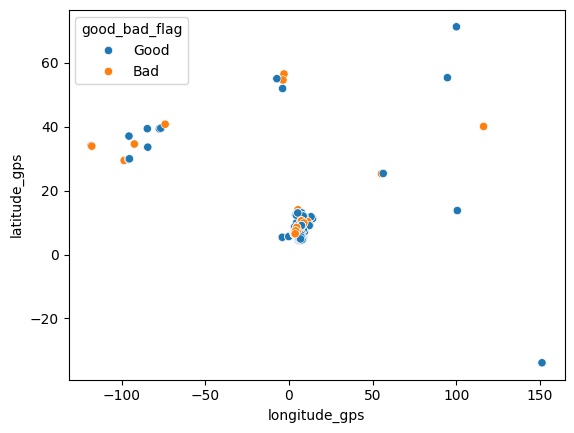

In [32]:
##plot the different locations on a scatter plot
sns.scatterplot(data=train_df,x='longitude_gps', y='latitude_gps', hue='good_bad_flag')


The scatter plot above shows that longitude and latitude has alot of outliers. It would be best to fill in their missing values with median rather than mean

In [67]:
# Drop target from features
X_train = train_data.drop('good_bad_flag', axis=1)


# Encode target
y_train = train_data['good_bad_flag'].map({'Good': 1, 'Bad': 0})

# One-hot encode object columns in features
object_cols = X_train.select_dtypes(include='object').columns.tolist()
X_train_encoded = pd.get_dummies(X_train, columns=object_cols, drop_first=False)
X_train_encoded=X_train_encoded.astype(int)

object_cols_test = test_data.select_dtypes(include='object').columns.tolist()
X_test= pd.get_dummies(test_data, columns=object_cols_test, drop_first=False)
X_test=X_test.astype(int)

X_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450 entries, 0 to 1449
Data columns (total 24 columns):
 #   Column                                   Non-Null Count  Dtype
---  ------                                   --------------  -----
 0   longitude_gps                            1450 non-null   int64
 1   latitude_gps                             1450 non-null   int64
 2   avgloanamount                            1450 non-null   int64
 3   avgtotaldue                              1450 non-null   int64
 4   prevloancount                            1450 non-null   int64
 5   prevgoodcount                            1450 non-null   int64
 6   probofpay                                1450 non-null   int64
 7   loanStatus                               1450 non-null   int64
 8   systemloanid                             1450 non-null   int64
 9   loannumber                               1450 non-null   int64
 10  loanamount                               1450 non-null   int64
 11  tota

Model Building

In [72]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
## fit a logistics model to train_X
model = LogisticRegression(random_state=0)
model.fit(X_train_scaled,y_train)
training_accuracy=accuracy_score(model.predict(X_train_scaled),y_train)
training_accuracy

0.7819926873857403